In [8]:
import elecboltz

import numpy as np
from scipy.constants import e, m_e, hbar, electron_volt

import matplotlib as mpl
from matplotlib import pyplot as plt

In [22]:
# matplotlib settings
# reset defaults
mpl.rcdefaults()
# font
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['pdf.fonttype'] = 3
# plotting
mpl.rcParams['figure.figsize'] = (7.48, 5.2)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 20

In [10]:
def calculate_drude(effective_mass, charge_density,
                    scattering_rate, magnetic_field):
    charge_mass = m_e * effective_mass
    omega_c = e * magnetic_field / charge_mass
    inverse_tensor = np.zeros((3, 3))
    np.fill_diagonal(inverse_tensor, scattering_rate)
    inverse_tensor[0, 1] = omega_c[2]
    inverse_tensor[1, 0] = -omega_c[2]
    inverse_tensor[0, 2] = -omega_c[1]
    inverse_tensor[2, 0] = omega_c[1]
    inverse_tensor[1, 2] = omega_c[0]
    inverse_tensor[2, 1] = -omega_c[0]
    return charge_density * e**2 / charge_mass * np.linalg.inv(inverse_tensor)

In [11]:
def make_bandstructure(kf, three_dimensional=False, **kwargs):
    dispersion = "Ef * (kx^2 + ky^2"
    if three_dimensional:
        dispersion += " + kz^2"
    dispersion += ")"

    a = np.pi / kf * 1e10
    coeff = hbar**2 / (2*m_e)
    Ef = coeff * kf**2 / electron_volt * 1e3
    bandstructure = elecboltz.BandStructure(
        dispersion, Ef, [a, a, a], band_params={'Ef': Ef}, **kwargs)
    bandstructure.discretize()
    return bandstructure

In [12]:
def loop_boltzmann_and_drude(conductivity, fields, scattering, charge_density):
    sigma_boltz_xx = np.empty(len(fields))
    sigma_boltz_xy = np.empty(len(fields))
    sigma_drude_xx = np.empty(len(fields))
    sigma_drude_xy = np.empty(len(fields))
    for i, field in enumerate(fields):
        conductivity.field = np.array([0, 0, field])
        conductivity.calculate()
        sigma_boltzmann = conductivity.sigma
        sigma_drude = calculate_drude(
            1, charge_density, scattering * 1e12, conductivity.field)
        sigma_boltz_xx[i] = sigma_boltzmann[0, 0]
        sigma_boltz_xy[i] = sigma_boltzmann[0, 1]
        sigma_drude_xx[i] = sigma_drude[0, 0]
        sigma_drude_xy[i] = sigma_drude[0, 1]
    return (sigma_boltz_xx, sigma_boltz_xy,
            sigma_drude_xx, sigma_drude_xy)

In [13]:
kf = 1e10
bandstructure = make_bandstructure(kf, periodic=2)
charge_density = kf**3 / (2 * np.pi**2)
fields = np.linspace(0, 30, 100)
scattering = 1.0
conductivity = elecboltz.Conductivity(
    bandstructure, scattering_rate=scattering)
sigma_boltz_xx, sigma_boltz_xy, sigma_drude_xx, sigma_drude_xy = loop_boltzmann_and_drude(
    conductivity, fields, scattering, charge_density)

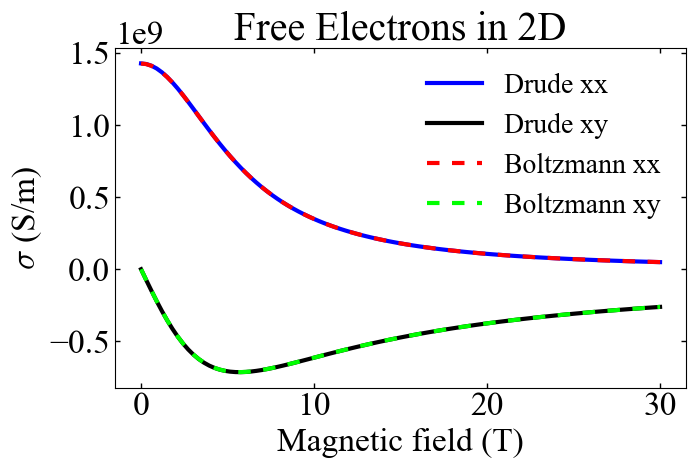

In [23]:
plt.plot(fields, sigma_drude_xx, label="Drude xx", color='blue')
plt.plot(fields, sigma_drude_xy, label="Drude xy", color='black')
plt.plot(fields, sigma_boltz_xx, label="Boltzmann xx",
         color='red', linestyle=(0, (3, 3)))
plt.plot(fields, sigma_boltz_xy, label="Boltzmann xy",
         color='lime', linestyle=(0, (3, 3)))
plt.xlabel("Magnetic field (T)")
plt.ylabel(r"$\sigma$ (S/m)")
plt.title("Free Electrons in 2D")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("Drude/boltzmann_vs_drude_2d.pdf", bbox_inches='tight')
plt.show()

In [24]:
kf = 1e10
scattering = 1.0
fields = np.linspace(0, 30, 100)
charge_density = kf**3 / (2 * np.pi**2)

resolutions = np.arange(10, 42)
errors = np.empty_like(resolutions, dtype=float)
for i, resolution in enumerate(resolutions):
    bandstructure = make_bandstructure(kf, resolution=resolution, periodic=2)
    conductivity = elecboltz.Conductivity(
        bandstructure, scattering_rate=scattering)
    sigma_boltz_xx, sigma_boltz_xy, sigma_drude_xx, sigma_drude_xy = loop_boltzmann_and_drude(
        conductivity, fields, scattering, charge_density)
    nonzeroxy = np.nonzero(sigma_drude_xy)
    errors[i] = max(
        np.max(np.abs(sigma_boltz_xx-sigma_drude_xx) / sigma_drude_xx),
        np.max(np.abs(sigma_boltz_xy-sigma_drude_xy)[nonzeroxy]
               / sigma_drude_xy[nonzeroxy]))

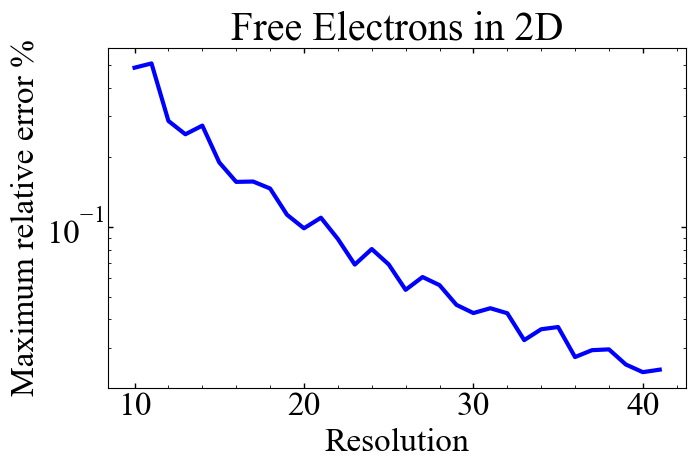

In [26]:
plt.semilogy(resolutions, 100 * errors, color='blue')
plt.minorticks_on()
plt.xlabel("Resolution")
plt.ylabel("Maximum relative error %")
plt.title("Free Electrons in 2D")
plt.tight_layout()
plt.savefig("Drude/boltzmann_vs_drude_2d_error.pdf", bbox_inches='tight')
plt.show()